Import packages and load dataframe for modeling. 

In [18]:
import pandas as pd 
from pandas import ExcelWriter
from pandas import ExcelFile
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import requests
import json
from bs4 import BeautifulSoup as bs
import re
import seaborn as sns
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn import tree 
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pandas as pd 
import numpy as np 
from sklearn import preprocessing
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score


In [4]:
df_final = pd.read_csv('fullmodelset1.csv')

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
df_final = df_final.drop('Unnamed: 0', axis=1)

In [7]:
df_final.head()

,binned source EUI,Number of Buildings,Gross Floor Area,Year Built,Median Income for Zip,gas_heat,gas_water,gas_equip,elec_heat,elec_lighting,elec_equipment,elec_fans,elec_ref,elec_cool,elec_percent_total,bor_Brooklyn,bor_Manhattan,bor_Queens,bor_Staten Island,type_Distribution Center,type_Enclosed Mall,type_Hospital (General Medical & Surgical),type_Hotel,type_K-12 School,type_Medical Office,type_Multifamily Housing,type_Non-Refrigerated Warehouse,type_Office,type_Other - Education,type_Other - Lodging/Residential,type_Other - Mall,type_Other - Specialty Hospital,type_Refrigerated Warehouse,type_Residence Hall/Dormitory,type_Residential Care Facility,type_Retail Store,type_Senior Care Community,type_Strip Mall,type_Supermarket/Grocery Store,star_Low,star_Moderate,star_Not Available
0,Extremely High,0.180882,0.536886,0.497395,0.944053,1.249428,-1.395162,-0.189896,-0.552515,-0.528153,-0.176898,-1.460124,-0.066904,1.300477,2.166622,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Extremely High,2.650070,14.117992,0.696392,-0.996745,0.429915,-1.269675,3.529133,-0.552515,-1.745510,-2.110497,0.066016,1.510391,3.741338,1.883785,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,Extremely High,2.650070,10.653319,-0.530756,1.223610,0.429915,-1.269675,3.529133,-0.552515,-1.745510,-2.110497,0.066016,1.510391,3.741338,1.883785,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,Extremely High,-0.066036,0.042888,-1.492575,0.358693,-0.026898,0.098773,-0.189896,0.123066,-0.399900,0.296489,0.008093,-0.066904,-0.176349,-0.622370,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Moderate,-0.066036,0.201764,-0.298593,-0.921523,-0.026898,0.098773,-0.189896,0.123066,-0.399900,0.296489,0.008093,-0.066904,-0.176349,-0.622370,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Define functions that will be helpful throughout modeling. 

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [46]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

Run decision tree model. After using grid search, it is clear that max depth of tree provides optimal accuracy when set at 5

In [51]:
X = df_final.drop('binned source EUI', axis=1)  
y = df_final['binned source EUI'] 

X_train, X_test , y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)



In [54]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth = 5)

clf.fit(X_train,y_train)

y_preds = clf.predict(X_test)

In [55]:
acc = accuracy_score(y_test,y_preds) * 100
print("Accuracy is :{0}".format(acc))

# Check the AUC for predictions
#false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_preds)
#roc_auc = auc(false_positive_rate, true_positive_rate)
#print("\nAUC is :{0}".format(round(roc_auc,2)))


# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_preds, rownames=['Actual'], colnames=['Predicted'], margins=True)

Accuracy is :64.11468178954001

Confusion Matrix
----------------


Predicted,Extremely High,High,Low,Moderate,All
Actual,,,,,
Extremely High,59,77,1,24,161
High,28,399,2,193,622
Low,0,69,628,79,776
Moderate,1,231,434,949,1615
All,88,776,1065,1245,3174


In [56]:
cm = confusion_matrix(y_test,y_preds)
classes = ['Extremely High', 'High', 'Moderate', 'Low']

Confusion Matrix, without normalization
[[ 59  77   1  24]
 [ 28 399   2 193]
 [  0  69 628  79]
 [  1 231 434 949]]


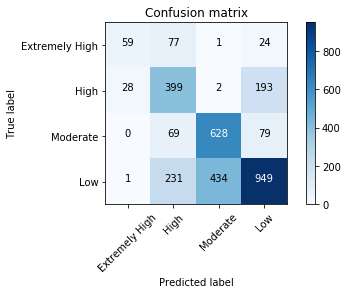

In [57]:
import itertools
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [40]:
print(confusion_matrix(y_test,y_preds))  
print(classification_report(y_test,y_preds)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, y_preds)))

[[ 58  79   0  24]
 [ 28 399   2 193]
 [  0  69 628  79]
 [  3 231 432 949]]
                precision    recall  f1-score   support

Extremely High       0.65      0.36      0.46       161
          High       0.51      0.64      0.57       622
           Low       0.59      0.81      0.68       776
      Moderate       0.76      0.59      0.66      1615

      accuracy                           0.64      3174
     macro avg       0.63      0.60      0.60      3174
  weighted avg       0.67      0.64      0.64      3174

The accuracy score is 0.6408317580340265


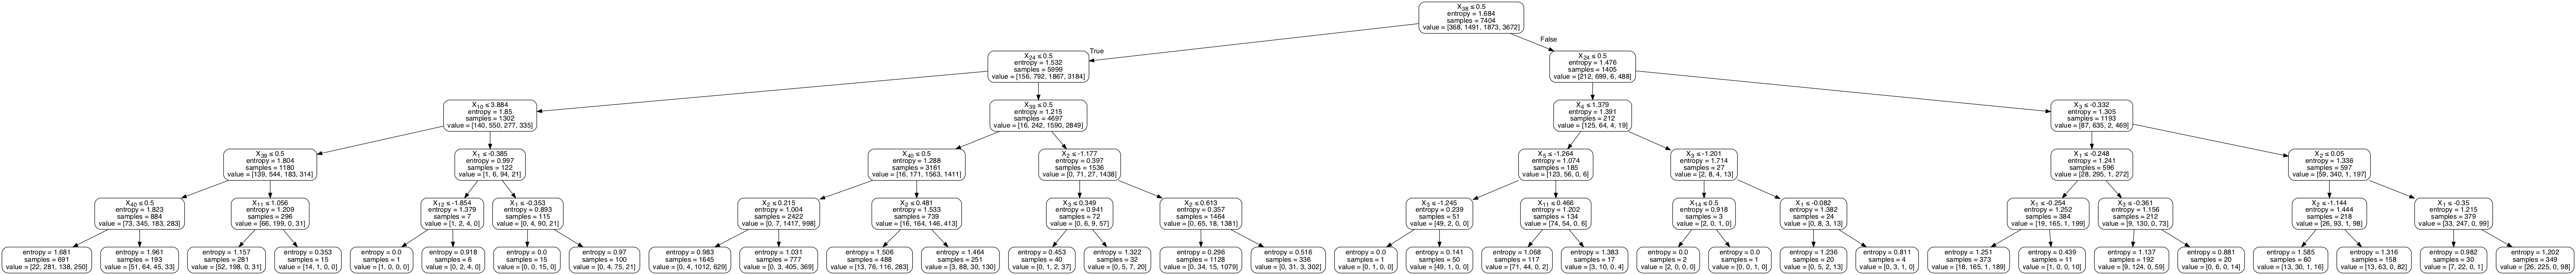

In [41]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [42]:
clasPred = clf.predict(X_test)

In [43]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, clasPred)

0.6408317580340265

Run this cell for a line graph of the cross value score, but be advised that you'll have to re-run the cells above before running the rest of the decision tree cells to get correct values. 

[0.4934784397124526, 0.5541250350356854, 0.5941934456913915, 0.584337034669326, 0.580560170237064, 0.5730125745690158, 0.5599681060778549, 0.5563754410427862, 0.5451259114283828]


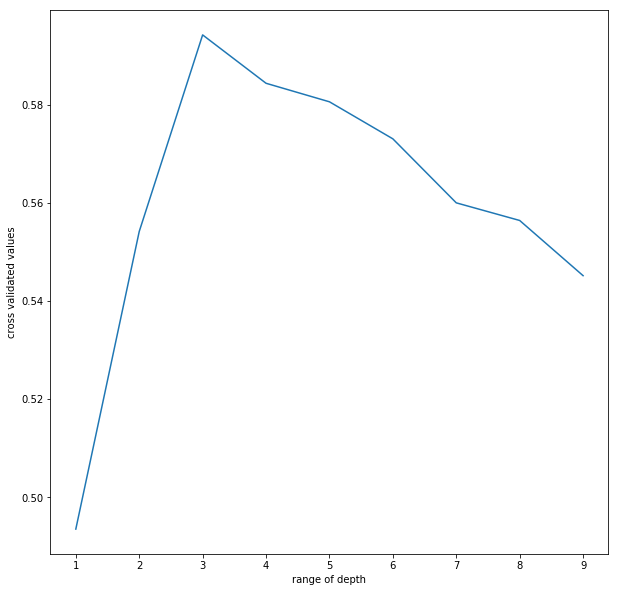

In [32]:
# score = cross_val_score(clf, X, y, cv = 10)
# score.mean()
# depth_range = range(1,10)
# val = []
# for depth in depth_range:
#     clf = DecisionTreeClassifier(max_depth = depth)
#     depth_score = cross_val_score(clf, X, y, cv = 10)
#     val.append(depth_score.mean())
# print(val)
# plt.figure(figsize = (10,10))
# plt.plot(depth_range, val)
# plt.xlabel('range of depth')
# plt.ylabel('cross validated values')
# plt.show()

In [44]:
clf.feature_importances_

array([0.        , 0.01155556, 0.02345147, 0.01067752, 0.0104823 ,
       0.00532964, 0.        , 0.        , 0.        , 0.        ,
       0.0332996 , 0.00837784, 0.00086908, 0.        , 0.00057808,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.27206227,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.25329617, 0.2484992 ,
       0.12152127])

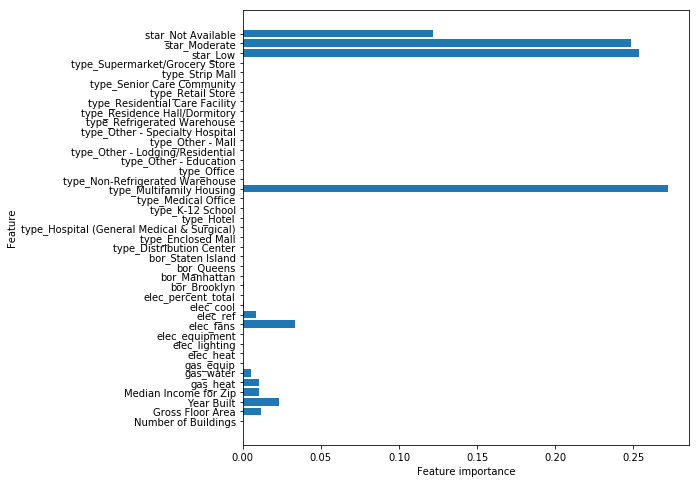

In [45]:
plot_feature_importances(clf)

The graph above is illustrative of a fundamental problem with this model - energy star features and multifamily housing category have an outsize impact on the final prediction. This may be because the modle has data leakage by including energy star rating. This rating is in itself a determined by building energy intensity, which is what this model is trying to classify. 

Run grid search to determine optimal hyperparameters. After these optimal hyperparameters were run, they were inserted into decision tree model above. 

In [47]:
dt_cv_score = cross_val_score(clf, X_train, y_train, cv=10)
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")

Mean Cross Validation Score: 63.20%


In [49]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [50]:
dt_grid_search = GridSearchCV(clf, dt_param_grid, cv=3, return_train_score=True)
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='entropy', max_depth=5,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                

In [58]:
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(X_train, y_train)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Testing Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 65.68%
Mean Testing Score: 65.45%
Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 5,
 'min_samples_split': 5}

Conclusion - Changing the parameters around doesn't result in much change in prediction accuracy. 

Run a bagged tree classifier model. 

In [59]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [60]:
X = df_final.drop('binned source EUI', axis=1)  
y = df_final['binned source EUI'] 

X_train, X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 50)



In [61]:
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='entropy', max_depth=5), n_estimators=20)

In [62]:
bagged_tree.fit(X_train, y_train)


BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='entropy',
                                                        max_depth=5,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
    

In [63]:
bagged_tree.score(X_train, y_train)

0.6622096164235548

In [64]:
bagged_tree.score(X_test, y_test)

0.6465028355387523

No significant change in accuracy.

Run random forest classifier. 

In [65]:
X = df_final.drop('binned source EUI', axis=1)  
y = df_final['binned source EUI'] 

X_train, X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 99)



In [66]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5, criterion='entropy')
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [67]:
forest.score(X_train, y_train)

0.587655321447866

In [68]:
forest.score(X_test, y_test)

0.5655324511657215

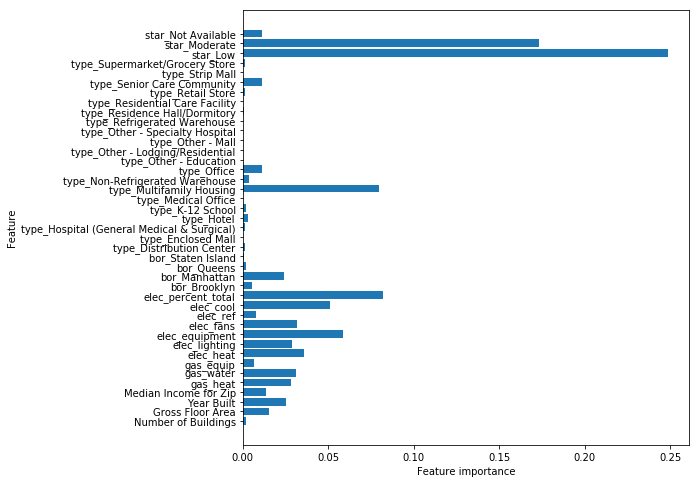

In [69]:
plot_feature_importances(forest)

Interesting change in feature important for random forest compared to single tree. 

Hyperparameter tuning for random forest

In [70]:
forest = RandomForestClassifier()
mean_rf_cv_score = np.mean(cross_val_score(forest, X_train, y_train, cv=3))

print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}")

/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Mean Cross Validation Score for Random Forest Classifier: 61.02%


In [71]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [72]:
import time
start = time.time()
rf_grid_search = GridSearchCV(forest, rf_param_grid, cv=3)
rf_grid_search.fit(X_train, y_train)

print(f"Testing Accuracy: {rf_grid_search.best_score_ :.2%}")
print(f"Total Runtime for Grid Search on Random Forest Classifier: {time.time() - start :.2f} seconds")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

KeyboardInterrupt: 

Run adaboost and use Grid Search to find best paramters. 

In [127]:
ada = AdaBoostClassifier()
adaboost_mean_cv_score = np.mean(cross_val_score(ada, X_train, y_train, cv=3))

print(f"Mean Cross Validation Score for AdaBoost: {adaboost_mean_cv_score :.2%}")

Mean Cross Validation Score for AdaBoost: 59.86%


In [128]:
adaboost_param_grid = {
    'n_estimators': [50, 100, 250],
    'learning_rate': [1.0, 0.5, 0.1]
}

In [129]:
adaboost_grid_search = GridSearchCV(ada, adaboost_param_grid, cv=3)
adaboost_grid_search.fit(X_train, y_train)

print(f"Testing Accuracy: {adaboost_grid_search.best_score_ :.2%}")
print(f"Total Runtime for Grid Search on AdaBoost: {time.time() - start :.2f} seconds")
print("")
print(f"Optimal Parameters: {adaboost_grid_search.best_params_}")

Testing Accuracy: 60.37%
Total Runtime for Grid Search on AdaBoost: 407.33 seconds

Optimal Parameters: {'learning_rate': 1.0, 'n_estimators': 100}


Now finally, let's try a Vector Machine Classifier (VCM)

In [137]:
from sklearn.svm import SVC  
from time import time
tic = time()
svclassifier = SVC(kernel='rbf', C=0.5)  
svclassifier.fit(X_train, y_train) 
y_pred = svclassifier.predict(X_test)
toc = time()
print("run time is {} seconds".format(toc-tic))

/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


run time is 6.925184011459351 seconds


In [138]:
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, y_pred)))

[[  0 124   4   9]
 [  0 502  16 119]
 [  0  52 626 105]
 [  0 331 464 822]]
                precision    recall  f1-score   support

Extremely High       0.00      0.00      0.00       137
          High       0.50      0.79      0.61       637
           Low       0.56      0.80      0.66       783
      Moderate       0.78      0.51      0.62      1617

      accuracy                           0.61      3174
     macro avg       0.46      0.52      0.47      3174
  weighted avg       0.64      0.61      0.60      3174

The accuracy score is 0.6143667296786389


/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [139]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [142]:
from sklearn import svm

In [143]:
svc_param_selection(X, y, 3)

{'C': 10, 'gamma': 0.001}

Re-run SVC with optimal parameters

In [144]:
from sklearn.svm import SVC  
from time import time
tic = time()
svclassifier = SVC(kernel='rbf', C=10, gamma=0.001)  
svclassifier.fit(X_train, y_train) 
y_pred = svclassifier.predict(X_test)
toc = time()
print("run time is {} seconds".format(toc-tic))

run time is 7.852621078491211 seconds


In [145]:
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, y_pred)))

[[  0 121   5  11]
 [  0 493  26 118]
 [  0  48 631 104]
 [  0 329 466 822]]
                precision    recall  f1-score   support

Extremely High       0.00      0.00      0.00       137
          High       0.50      0.77      0.61       637
           Low       0.56      0.81      0.66       783
      Moderate       0.78      0.51      0.62      1617

      accuracy                           0.61      3174
     macro avg       0.46      0.52      0.47      3174
  weighted avg       0.63      0.61      0.60      3174

The accuracy score is 0.6131064902331443


/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
